<a href="https://colab.research.google.com/github/RiceWater/New-Thesis-KFold-3CLS-No-Building/blob/main/Kaggle_3CLS_No_Building.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.9.3
aiosignal                        1.3.1
alabaster                        0.7.16
albumentations                   1.3.1
altair                           4.2.2
annotated-types                  0.6.0
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array_record                     0.5.1
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.1.0
attrs                            23.2.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.14.0
backcall                         0.2.0
beautifulsoup4                   4.12.3


In [3]:
!pip uninstall jax -y

Found existing installation: jax 0.4.26
Uninstalling jax-0.4.26:
  Successfully uninstalled jax-0.4.26


In [4]:
!pip install tensorflow==2.15.0

In [5]:
!python --version

Python 3.10.12


In [6]:
!pip install image_to_numpy==1.0.0

  Preparing metadata (setup.py) ... done
  Created wheel for image_to_numpy: filename=image_to_numpy-1.0.0-py3-none-any.whl size=3456 sha256=1a330789caee386aa11c70348b29eba1ed1980ed4d3ddd38d954381caf9a2726
  Stored in directory: /root/.cache/pip/wheels/4c/e5/7e/f10f47129bb75abc8cd52a8abbff926b4a6121990f926cfe6d
Successfully built image_to_numpy


In [7]:
!pip install neptune==1.9.1 neptune-tensorflow-keras==2.2.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 495.5/495.5 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 59.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.2/82.2 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 10.3 MB/s eta 0:00:00
  Created wheel for bravado-core: filename=bravado_core-6.1.1-py2.py3-none-any.whl size=67672 sha256=45422ebdff04693d7437ef8841cbbf448891adbf61e4daa79d80b01f88b29571
  Stored in directory: /root/.cache/pip/wheels/42/35/4a/44ec

In [8]:
import tqdm
import os
import cv2
import imghdr
import image_to_numpy
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime
import itertools
from numpy.random import default_rng

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomContrast, RandomBrightness, Rescaling, Resizing
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, ReLU
from tensorflow.keras.metrics import F1Score, Precision, Recall, CategoricalAccuracy
from tensorboard.plugins.hparams import api as hp
import sklearn
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import StratifiedKFold

from time import perf_counter
import math

import neptune
from neptune.integrations.tensorflow_keras import NeptuneCallback

In [9]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Thesis Related/4-600-Dataset'):
    print(os.path.join(dirname))


/content/drive/MyDrive/Thesis Related/4-600-Dataset
/content/drive/MyDrive/Thesis Related/4-600-Dataset/Road
/content/drive/MyDrive/Thesis Related/4-600-Dataset/Vehicle
/content/drive/MyDrive/Thesis Related/4-600-Dataset/Plant
/content/drive/MyDrive/Thesis Related/4-600-Dataset/Building


In [10]:
def make_model(params):
    model = Sequential()
    model.add(RandomFlip(mode='horizontal', seed=1, input_shape=(256,256,3)))
    model.add(RandomRotation(factor=0.2, seed=1))

    model.add(Conv2D(input_shape=(256,256,3), filters=16, kernel_size=(3,3), padding="same"))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling2D())

    model.add(Conv2D(filters=16, kernel_size=(3,3), padding="same"))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling2D())

    model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same"))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling2D())

    model.add(Flatten())
    model.add(Dropout(0.2, seed=1))
    model.add(Dense(units=128,activation="relu"))
    model.add(Dense(units=64,activation="relu"))

    model.add(Dense(units=3, activation="softmax"))


    optimizer = tf.keras.optimizers.Adam(
        learning_rate=params["lr"],
    )

    model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [11]:
def create_callbacks(counter):
    neptune_cbk = NeptuneCallback(run=run, base_namespace="training")

    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path + str(counter),
                                                                 monitor='val_loss',
                                                                 mode='auto',
                                                                 save_best_only=True,
                                                                 verbose=1)
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                   patience=15,
                                                  )
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                         factor=0.6,
                                                         patience=5,
                                                         min_delta=0.001,
                                                         mode='auto',
                                                         verbose=1)
#     return [reduce_lr, cp_callback, es_callback]
    return [neptune_cbk, reduce_lr, cp_callback, es_callback]

In [12]:
def plot_loss(hist):
    fig = plt.figure(figsize=(3,2))
    plt.plot(hist.history['loss'], color='teal', label='loss')
    plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
    plt.suptitle('Loss')
    plt.legend(loc='upper right')
    plt.show()
    return fig

def plot_acc(hist):
    fig = plt.figure(figsize=(3,2))
    plt.plot(hist.history['accuracy'], color='teal', label='acc')
    plt.plot(hist.history['val_accuracy'], color='orange', label='val_acc')
    plt.suptitle('Accuracy')
    plt.legend(loc='upper left')
    plt.show()
    return fig

def avg_rate(metric_list):
    return sum(metric_list) / len(metric_list)

In [13]:
with tf.device('/gpu:0'):
    labels = ['Plant', 'Road', 'Vehicle']
    X_train = []
    y_train = []
    y_label_idx = []
    image_size = 256
    for i in labels:
        folderPath = os.path.join('/content/drive/MyDrive/Thesis Related/4-600-Dataset', i)
        for j in os.listdir(folderPath):
            img = image_to_numpy.load_image_file(os.path.join(folderPath,j))
            img = cv2.resize(img,(image_size, image_size))
            X_train.append(img)
            y_label_idx.append(labels.index(i))

In [14]:
X_train = np.array(X_train)
y_label_idx = np.array(y_label_idx)

X_train_scaled = X_train.astype(np.float32) / 255.0

In [15]:
# seed ensures that the generation are the same from local and kaggle
rng = default_rng(seed=1)

plants_test_idx = rng.choice(np.arange(0,600), size=120, replace=False)
roads_test_idx = rng.choice(np.arange(600,1200), size=120, replace=False)
vehicles_test_idx = rng.choice(np.arange(1200,1800), size=120, replace=False)
total_test_idx = np.concatenate((plants_test_idx, roads_test_idx, vehicles_test_idx), axis=None)
print(total_test_idx[:20])

[273 397 467 471 105 584 208 456  32 573 462 540 261 134 460 229 494 293
 412 515]


In [16]:
def train_test_X(X_train_scaled):
    test_x = X_train_scaled[total_test_idx]
    train_x = np.delete(X_train_scaled, total_test_idx, axis=0)
    return train_x, test_x

def train_test_y(y_label_idx):
    test_y = y_label_idx[total_test_idx]
    train_y = np.delete(y_label_idx, total_test_idx, axis=0)
    return train_y, test_y

In [17]:
train_x, holdout_x = train_test_X(X_train_scaled)
train_y, holdout_y = train_test_y(y_label_idx)

## KFOLD

In [22]:
!mkdir MODEL

In [23]:
!ls ./

drive  MODEL  sample_data


In [26]:
model_name= 'Model 3CLS-4.0.1'
checkpoint_path = f'/content/MODEL/{model_name}/FOLD-'
kfold = StratifiedKFold(n_splits=8, shuffle=True, random_state=1)
project_name='New-Thesis/Kaggle-3Cls-No-Building'

[neptune] [info   ] Neptune initialized. Open in the app: offline/a9ddfcd6-0d96-4317-8622-d88ce9545bba


[neptune] [warning] NeptuneWarning: The following monitoring options are disabled by default in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', and 'capture_hardware_metrics'. To enable them, set each parameter to 'True' when initializing the run. The monitoring will continue until you call run.stop() or the kernel stops. Also note: Your source files can only be tracked if you pass the path(s) to the 'source_code' argument. For help, see the Neptune docs: https://docs.neptune.ai/logging/source_code/


Epoch 1/2
90/90 [==============================] - ETA: 0s - loss: 2.2887 - accuracy: 0.6931
Epoch 1: val_loss improved from inf to 5.61228, saving model to /content/MODEL/Model 3CLS-4.0.1---TEST/FOLD-0
90/90 [==============================] - 101s 1s/step - loss: 2.2887 - accuracy: 0.6931 - val_loss: 5.6123 - val_accuracy: 0.3361 - lr: 0.0010
Epoch 2/2
90/90 [==============================] - ETA: 0s - loss: 1.3225 - accuracy: 0.7708
Epoch 2: val_loss improved from 5.61228 to 1.99699, saving model to /content/MODEL/Model 3CLS-4.0.1---TEST/FOLD-0
90/90 [==============================] - 75s 833ms/step - loss: 1.3225 - accuracy: 0.7708 - val_loss: 1.9970 - val_accuracy: 0.4556 - lr: 0.0010


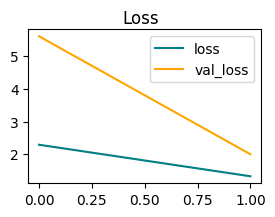

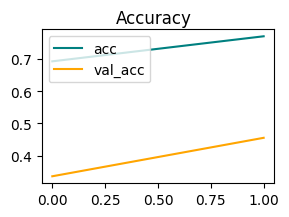

Fold Training Time: 0 hour(s) and 3 mins
Precision: 46.02272808551788  -  Recall: 44.999998807907104
Accuracy: 45.55555582046509
F1Score-P: 4.878048896789551
F1Score-R: 61.268550872802734
F1Score-V: 41.942604064941406
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/f68f55c2-c4ea-4b16-bd53-e5b6b4941bf7
Epoch 1/2
90/90 [==============================] - ETA: 0s - loss: 1.6405 - accuracy: 0.7444
Epoch 1: val_loss improved from inf to 1.90849, saving model to /content/MODEL/Model 3CLS-4.0.1---TEST/FOLD-1
90/90 [==============================] - 75s 815ms/step - loss: 1.6405 - accuracy: 0.7444 - val_loss: 1.9085 - val_accuracy: 0.5028 - lr: 0.0010
Epoch 2/2
90/90 [==============================] - ETA: 0s - loss: 0.8718 - accuracy: 0.7764
Epoch 2: val_loss did not improve from 1.90849
90/90 [==============================] - 78s 873ms/step - loss: 0.8718 - accuracy: 0.7764 

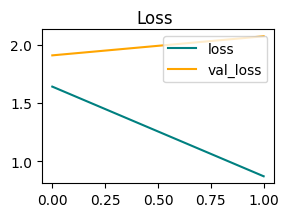

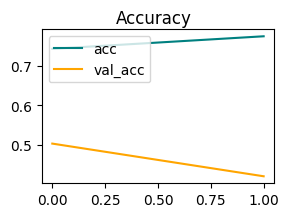

Fold Training Time: 0 hour(s) and 2 mins
Precision: 50.490885972976685  -  Recall: 50.0
Accuracy: 50.27777552604675
F1Score-P: 0.0
F1Score-R: 63.988101959228516
F1Score-V: 55.681819915771484
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
Total Training Time: 0 hour(s) and 7 mins


In [27]:
params = {
    "lr": 0.001,
    "epochs": 25,
    "batch_size": 8}

precisions = []
recalls = []
accuracies = []
f1_plant = []
f1_road = []
f1_vcl = []

with tf.device('/gpu:0'):
    counter = 0
    start = perf_counter()
    for train, test in kfold.split(train_x, train_y):
        start_fold = perf_counter()

        run = neptune.init_run(
            name= f"{model_name}-FOLD_{counter}",
            project=project_name,
            mode="offline",     # To prevent issue when internet sucks. Just manually sync it
            )  # your credentials

        run["parameters"] = params


        model = make_model(params)
        cat_y = tf.keras.utils.to_categorical(train_y)

        train_dataset = tf.data.Dataset.from_tensor_slices((train_x[train], cat_y[train]))
        train_fold = train_dataset.shuffle(buffer_size=train_dataset.cardinality(), seed=1).batch(params['batch_size'])

        test_dataset = tf.data.Dataset.from_tensor_slices((train_x[test], cat_y[test]))
        test_fold = test_dataset.shuffle(buffer_size=test_dataset.cardinality(), seed=1).batch(params['batch_size'])

        hist = model.fit(train_fold,
                         validation_data=test_fold,
                         batch_size=params['batch_size'],
                         epochs=params['epochs'],
                         verbose=1,
                         callbacks=create_callbacks(counter))
        end_fold = perf_counter()

        # PLOTTING ==================================================
        run["fig-train_loss"].upload(plot_loss(hist))
        run["fig-train_acc"].upload(plot_acc(hist))

        # EVALUATING ==================================================
        model = tf.keras.models.load_model(checkpoint_path + str(counter))

        pre = Precision()
        rec = Recall()
        c_acc = CategoricalAccuracy()
        f1_score = F1Score()
        for batch in test_fold.as_numpy_iterator():
            X, y = batch
            yhat = model.predict(X, verbose=0)
            pre.update_state(y, yhat)
            rec.update_state(y, yhat)
            c_acc.update_state(y, yhat)
            f1_score.update_state(y, yhat)


        precisions.append(pre.result().numpy() * 100)
        recalls.append(rec.result().numpy() * 100)
        accuracies.append(c_acc.result().numpy() * 100)
        f1_s = f1_score.result().numpy() * 100

        f1_plant.append(f1_s[0])
        f1_road.append(f1_s[1])
        f1_vcl.append(f1_s[2])

        run["eval/ACC/"] = accuracies[counter]
        run["eval/REC/"] = recalls[counter]
        run["eval/PRE/"] = precisions[counter]
        run["eval/F1-P"] = f1_plant[counter]
        run["eval/F1-R"] = f1_road[counter]
        run["eval/F1-V"] = f1_vcl[counter]

        # SAVE MODEL TO NEPTUNE AI =======================================
        model_save_path = f'{checkpoint_path}{counter}/{model_name}-FOLD-{counter}.keras'
        model.save(model_save_path)
        run['checkpoint/model'].upload(model_save_path)

        # PRINTING RESULTS ===========================================
        print(f'Fold Training Time: {math.floor((end_fold-start_fold)/3600) } hour(s) and {math.floor((end_fold-start_fold)/60)%60} mins')
        print(f'Precision: {precisions[counter]}  -  Recall: {recalls[counter]}')
        print(f'Accuracy: {accuracies[counter]}')
        print(f'F1Score-P: {f1_plant[counter]}')
        print(f'F1Score-R: {f1_road[counter]}')
        print(f'F1Score-V: {f1_vcl[counter]}')

        run.stop()

        counter += 1

    end = perf_counter()
    print(f'Total Training Time: {math.floor((end-start)/3600) } hour(s) and {math.floor((end-start)/60)%60} mins')

In [28]:
print(f"""
Avg Accuracy: {avg_rate(accuracies)}
Avg Precision: {avg_rate(precisions)}
Avg Recall: {avg_rate(recalls)}
Avg F1-Score-P: {avg_rate(f1_plant)}
Avg F1-Score-R: {avg_rate(f1_road)}
Avg F1-Score-V: {avg_rate(f1_vcl)}
""")


Avg Accuracy: 47.91666567325592
Avg Precision: 48.256807029247284
Avg Recall: 47.49999940395355
Avg F1-Score-P: 2.4390244483947754
Avg F1-Score-R: 62.628326416015625
Avg F1-Score-V: 48.812211990356445



In [29]:
run = neptune.init_run(
            name= f"{model_name}-AVG",
            project=project_name,
            mode="offline",     # To prevent issue when internet sucks. Just manually sync it
            )

run["eval/PRE/"] = avg_rate(precisions)
run["eval/REC/"] = avg_rate(recalls)
run["eval/ACC/"] = avg_rate(accuracies)
run["eval/F1-P"] = avg_rate(f1_plant)
run["eval/F1-R"] = avg_rate(f1_road)
run["eval/F1-V"] = avg_rate(f1_vcl)

run.stop()

[neptune] [info   ] Neptune initialized. Open in the app: offline/982ad140-5b15-45fb-b60d-9ff5001c29cf
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!


In [30]:
os.environ['NEPTUNE_API_TOKEN'] = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJiM2YzNGEwOC1iNmYyLTQ3YTEtYTljNi0xOWNmYWE0ZjZjOTMifQ=="

In [31]:
!neptune sync -p 'New-Thesis/Kaggle-3Cls-No-Building' --offline-only


Offline container 9bd3da20-7095-4cc9-b202-f2c8258bd512 registered as New-Thesis/Kaggle-3Cls-No-Building/K3NB-1
Synchronising New-Thesis/Kaggle-3Cls-No-Building/K3NB-1
Deleted: /content/.neptune/async/run__9bd3da20-7095-4cc9-b202-f2c8258bd512__13655__aes8uplv
Synchronization of run New-Thesis/Kaggle-3Cls-No-Building/K3NB-1 completed.
Offline container 9bd3da26-7c27-4769-93ed-fa03226d5ea2 registered as New-Thesis/Kaggle-3Cls-No-Building/K3NB-2
Synchronising New-Thesis/Kaggle-3Cls-No-Building/K3NB-2
Deleted: /content/.neptune/async/run__9bd3da26-7c27-4769-93ed-fa03226d5ea2__13655__k7g844yk
Synchronization of run New-Thesis/Kaggle-3Cls-No-Building/K3NB-2 completed.
Offline container 9bd3da2c-3af2-46a7-8e82-ad8adf27ce7a registered as New-Thesis/Kaggle-3Cls-No-Building/K3NB-3
Synchronising New-Thesis/Kaggle-3Cls-No-Building/K3NB-3
Deleted: /content/.neptune/async/run__9bd3da2c-3af2-46a7-8e82-ad8adf27ce7a__13655__tdei7iuj
Synchronization of run New-Thesis/Kaggle-3Cls-No-Building/K3NB-3 comple

In [32]:
!neptune clear
